In [2]:
import os
import pandas as pd
import numpy as np
import urllib
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from gekko import GEKKO

In [3]:
path = r'C:\Users\student\Documents\Alistair CoAgMET Projects\Pythonstuff\QC\normals\tmean_regression'
csv = r'C:\Users\student\Documents\Alistair CoAgMET Projects\Pythonstuff\QC\normals\tmean_regression\csv.csv'
f = open(csv,'w+')

In [4]:
urllib.request.urlretrieve(
    'http://coagmet.colostate.edu/cgi-bin/web_services.pl?type=daily&sids=akr02&sdate=1992-07-01&edate=2018-12-31&elems=tave,tmax,tmin',
    filename=csv)
df = pd.read_csv(csv)
df = df.reset_index()
df.columns.values[0] = 'station'
df.columns.values[1] = 'date'
df.columns.values[2] = 'tave'
df.columns.values[3] = 'tmax'
df.columns.values[4] = 'tmin'
df['date'] = pd.to_datetime(df.date)
df['julian'] = df.date.dt.strftime('%j')

df.tave = df.tave.astype(float)
df.tmin = df.tmin.astype(float)
df.tmax = df.tmax.astype(float)


df.tmax = 32 + (df.tmax * (9/5))
df.tmin = 32 + (df.tmin * (9/5))

df.tave = (df.tmax + df.tmin) /2

df = df.replace('M', np.nan, regex=True)
df

,station,date,tave,tmax,tmin,julian
0,akr02,1992-07-01,61.7720,70.0340,53.5100,183
1,akr02,1992-07-02,58.1720,69.1880,47.1560,184
2,akr02,1992-07-03,65.3900,83.8220,46.9580,185
3,akr02,1992-07-04,75.3800,92.4980,58.2620,186
4,akr02,1992-07-05,67.7750,79.4660,56.0840,187
5,akr02,1992-07-06,81.2390,98.5100,63.9680,188
6,akr02,1992-07-07,74.1110,87.6020,60.6200,189
7,akr02,1992-07-08,69.6920,78.6020,60.7820,190
8,akr02,1992-07-09,74.6510,89.2940,60.0080,191
9,akr02,1992-07-10,67.0280,78.1160,55.9400,192


In [5]:
norms = df.groupby(['julian']).mean().reset_index()
norms = norms[:-1]
norms.julian = norms.julian.astype(int)
norms.tave = norms.tave.astype(float)
norms

,julian,tave,tmax,tmin
0,1,18.767545,31.373600,6.161491
1,2,30.610450,44.449500,16.771400
2,3,30.519680,43.847960,17.191400
3,4,24.353240,37.274630,11.431850
4,5,25.110365,39.210350,11.010380
5,6,22.799489,37.765684,7.833295
6,7,25.939445,39.153560,12.725330
7,8,28.906295,41.961560,15.851030
8,9,27.582035,40.035740,15.128330
9,10,29.208245,41.547380,16.869110


In [6]:
m = GEKKO()
n = len(norms['julian'])
julian = norms.julian.values
tave = norms.tave.values
m.x = m.Param(value=np.linspace(1,366,num=52))
m.y = m.Var()
m.cspline(m.x,m.y,julian,tave)
m.options.IMODE = 2
m.solve(disp=False)

TypeError: object of type 'NoneType' has no len()

In [8]:
s = UnivariateSpline(julian,tave,k=5,s=1500)
ys = s(julian)

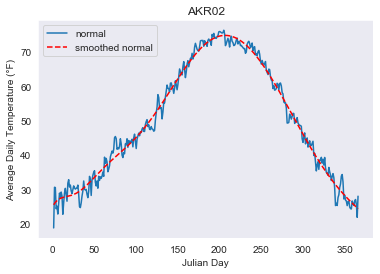

In [23]:
sns.set_style('dark')
ax = sns.lineplot(julian,tave,label='normal',palette='color_blind')
ax.set_title('AKR02')
plt.ylabel('Average Daily Temperature (°F)')
plt.xlabel('Julian Day')
plt.plot(julian,ys,'r--',label='smoothed normal')
plt.legend()
plt.show()



In [183]:
score = r2_score(tave,ys)
score

0.9851759102433719

In [184]:
ys

array([25.51077191, 25.87830924, 26.19725753, 26.47272719, 26.70953915,
       26.9122324 , 27.0850715 , 27.23205407, 27.35691834, 27.46315062,
       27.55399284, 27.63245005, 27.70129794, 27.76309033, 27.82016672,
       27.87465977, 27.92850281, 27.98343738, 28.04102071, 28.10263328,
       28.16948624, 28.24262904, 28.32295684, 28.41121809, 28.50802199,
       28.61384605, 28.72904358, 28.85385117, 28.98839626, 29.13270462,
       29.28670786, 29.45025095, 29.62309972, 29.80494841, 29.99542711,
       30.19410935, 30.40051956, 30.61414059, 30.83442125, 31.0607838 ,
       31.29263143, 31.52935584, 31.77034472, 32.01498922, 32.26269153,
       32.51287236, 32.76497844, 33.01849   , 33.27292626, 33.5278463 ,
       33.78284792, 34.0375665 , 34.29167383, 34.54487694, 34.79691697,
       35.04756798, 35.2966358 , 35.54395686, 35.78939705, 36.03285053,
       36.27423861, 36.51350853, 36.75063235, 36.98560578, 37.21844699,
       37.44919549, 37.67791093, 37.90467196, 38.12957508, 38.35

In [185]:
j_day = norms['julian']
j_day = j_day.reset_index()
series = pd.Series(ys)
df2 = series.reset_index()
norms = df2.merge(j_day)
norms.columns.values[1] = 'tave'
norms

,index,tave,julian
0,0,25.510772,1
1,1,25.878309,2
2,2,26.197258,3
3,3,26.472727,4
4,4,26.709539,5
5,5,26.912232,6
6,6,27.085071,7
7,7,27.232054,8
8,8,27.356918,9
9,9,27.463151,10


In [103]:
t = norms['julian'].values
temp = norms['tave'].values
c, cov = curve_fit(lob,t,temp)
print(c)

[-4.13278035e-06  7.55170686e-04  2.51944125e-01  2.07661597e+01]


In [127]:
m.y

[18.767545455, 28.836800242, 30.039069834, 28.892554775, 31.113069132, 32.166928258, 33.590949065, 31.773263486, 33.145335742, 36.60081663, 40.747610039, 42.066452142, 43.03341135, 43.766800253, 45.036928131, 47.658259534, 48.284972053, 49.049962419, 54.113621312, 60.365782728, 59.14816406, 63.726360702, 63.526902794, 67.944105068, 70.934581074, 73.460400078, 73.737932013, 73.970643765, 75.769441381, 72.949471344, 72.8320451, 72.897343545, 70.996611414, 71.221843423, 69.401198143, 67.245211581, 64.416420099, 59.135135043, 60.984164811, 53.23886725, 51.56507007, 48.986577009, 46.439444498, 43.01845018, 35.42731804, 37.657519995, 34.519363161, 32.606797851, 31.086253774, 26.690632682, 26.365705072, 28.0016]

In [104]:
n = len(norms['julian'])
y = np.empty(n)
for i in range(n):
    y[i] = lob(norms.julian[i],c[0],c[1],c[2],c[3])
y

array([21.01885488, 21.27303559, 21.52867705, 21.78575445, 22.04424302,
       22.30411794, 22.56535442, 22.82792766, 23.09181288, 23.35698526,
       23.62342002, 23.89109236, 24.15997747, 24.43005058, 24.70128687,
       24.97366155, 25.24714983, 25.5217269 , 25.79736797, 26.07404825,
       26.35174294, 26.63042724, 26.91007635, 27.19066548, 27.47216983,
       27.75456461, 28.03782501, 28.32192625, 28.60684351, 28.89255202,
       29.17902697, 29.46624356, 29.754177  , 30.04280249, 30.33209523,
       30.62203043, 30.91258329, 31.20372902, 31.49544281, 31.78769988,
       32.08047542, 32.37374463, 32.66748273, 32.96166491, 33.25626638,
       33.55126234, 33.84662799, 34.14233854, 34.43836919, 34.73469514,
       35.03129161, 35.32813378, 35.62519687, 35.92245607, 36.21988659,
       36.51746364, 36.81516242, 37.11295812, 37.41082596, 37.70874114,
       38.00667885, 38.30461432, 38.60252272, 38.90037928, 39.19815919,
       39.49583766, 39.79338989, 40.09079108, 40.38801644, 40.68

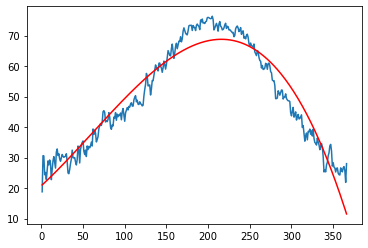

In [105]:
plt.plot(norms.julian,norms.tave)
plt.plot(norms.julian,y,'r')
plt.show()

0.9184672346849927